# 0.0. IMPORTS

In [1]:
import inflection
import datetime
import warnings
import random
import pickle # to save the results, and avoid the need for run xgbregressor again
import math

warnings.filterwarnings('ignore')

import seaborn as sns
import xgboost as xgb
import pandas  as pd
import numpy   as np

from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from IPython.display       import Image  # class display
from IPython.core.display  import HTML

from matplotlib            import pyplot as plt
from scipy                 import stats  as ss

## 0.1 Helper Functions

In [2]:
# after of take off the test dataset, get the training set and split it again in training and validation set
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, 6)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7) # 6 weeks
        validation_end_date   = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        # filtering dataset
        training   = x_training[ x_training['date']  <  validation_start_date]
        validation = x_training[(x_training['date']  >= validation_start_date) &
                                (x_training['date']  <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list. append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        #print(lr_result)
        
    return pd.DataFrame(
    {'Model Name': model_name,
     'MAE CV' : np.round(np.mean(mae_list ), 2).astype(str)  + '+/-' + np.round(np.std(mae_list ), 2).astype(str),
     'MAPE CV': np.round(np.mean(mape_list), 2).astype(str)  + '+/-' + np.round(np.std(mape_list), 2).astype(str),
     'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str)  + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, 
        index = [0])

def mean_percentage_error(y, yhat):
    return np.mean(((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cramer_v(x, y):
    # Cramér's V is a measure of association between two nominal variables
    cm   = pd.crosstab(x, y).values  # confusion matrix
    n    = cm.sum()
    r, k = cm.shape
    
    chi2     = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) # corr -> correction of parameters
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows    = None
    #pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) # False to the function get all data in the archive
df_store_raw = pd.read_csv('data/store.csv', low_memory = False) # False to the function get all data in the archive

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 STEP 01 - DATA DESCRIPTION (crisp - data cleaning)

## 1.1 Rename Columns (Facilitate the description)

In [5]:
df1 = df_raw.copy() # to avoid damage in the original data, make a copy in each section of the notebook

# importing reduced data set of 500000 rows only
df1 = pd.read_csv('data/short_df.csv')
df1 = df1.drop(['Unnamed: 0', 'month_map', 'is_promo'], axis = 1)
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
1,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
2,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12,2013,0,31,2015,0
3,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4,2013,0,31,2015,0
4,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0,31,2015,0


In [6]:
# code to eliminate randomly rows from de raw dataset and save the new csv file
#for i in range(100):
#    df1 = df1.drop(df1.sample(5000).index)
#    
#df1 = df1.drop(df1.sample(17209).index).reset_index()
#df1 = df1.drop(['index'], axis = 1)
#df1.shape

#df1.to_csv('short_df.csv')

In [7]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new  = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data dimension

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 500000
Number of cols: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum() # now is all zero because of the new shorter dataset charged previously

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.5 Fillout NA

In [12]:
# three ways to deal with na
# first - exclude the na
# second - using machine learning to substitute bay median, average, etc...
# third - analysing the data and make an adequation

In [13]:
df1['competition_distance'].max()

200000.0

In [14]:
# competition_distance: we are assuming tha when there is no competition distance, the competition doesn't exists 
# at all, so we assumy tha this distance will be 200000, a number much higher than the value 75860.0

# 200000.0 if math.isnam(df1['competition_distance']) else df1['competition_distance']
# lambda x: 200000.0 if math.isnam(x['competition_distance']) else x['competition_distance']
# df1['competition_distance'].apply(lambda x: 200000.0 if math.isnam(x) else x)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month: we are assuming that the month of competition openning is the same as the month of 
# the sale column
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(
                                                        lambda x: x['date'].month 
                                                        if math.isnan(x['competition_open_since_month']) 
                                                        else x['competition_open_since_month'],
                                                        axis = 1) # because we are using more than one column, we 
                                                        # need do specify that apply function will be apllied along
                                                        # the columns.

# competition_open_since_year     
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(
                                                        lambda x: x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'],
                                                        axis = 1)
                       
# promo2_since_week: we are assuming the same date of the row, i.e., the store doesn't make the promo2
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(
                                                        lambda x: x['date'].week 
                                                        if math.isnan(x['promo2_since_week']) 
                                                        else x['promo2_since_week'],
                                                        axis = 1)

# promo2_since_year  
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year 
                                                        if math.isnan(x['promo2_since_year']) 
                                                        else x['promo2_since_year'],
                                                        axis = 1)

# promo_interval: built a list and if the date is on the list the promo was made
# dictionare
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 
             11: 'Noc', 12: 'Dec'}

# fill with 0 where in no values
df1['promo_interval'].fillna(0, inplace = True) # inplace so the command doesn't return any value and make the 
                                                # modification directly to the column

df1['month_map'] = df1['date'].dt.month.map(month_map) # trasnform date column in date and month, and substitute
                                                       # the numbers by letters

# if the months of 'month_map' are in 'promo_interval', so we assume that the store make the promo and the time
df1['is_promo']  = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                         if x['promo_interval'] == 0 
                                                         else 1 
                                                         if x['month_map'] in x['promo_interval'].split(',') 
                                                         else 0, 
                                                         axis = 1)


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [16]:
# to verify if the previous changes alterate the types values
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']            = df1['promo2_since_week'].astype(int)
df1['promo2_since_year']            = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [18]:
# separating numerical and categorical variables
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

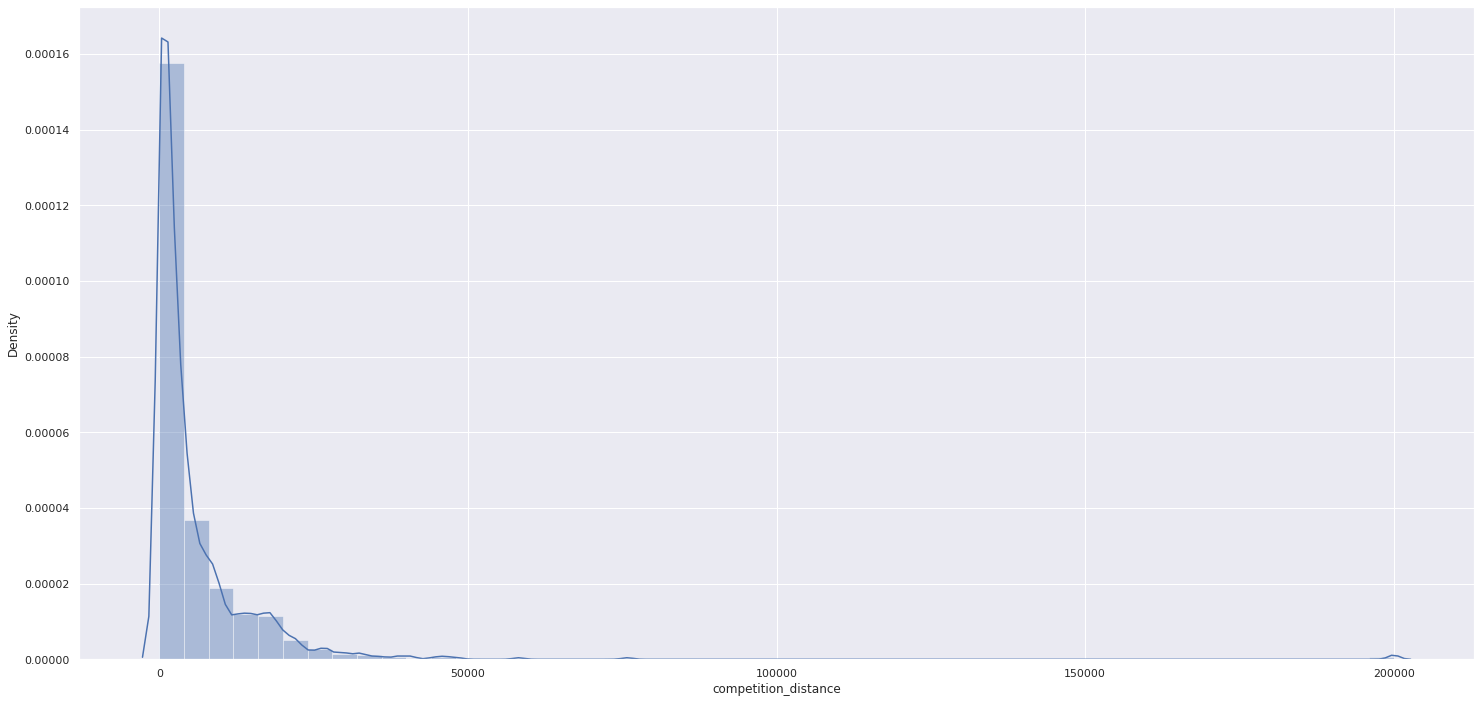

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T # transform to dataframe to facilitate visualization
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T # skewness
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

sns.distplot(df1['competition_distance'])

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.790824,559.0,322.169938,-0.002008,-1.201548
1,day_of_week,1.0,7.0,6.0,3.997966,4.0,1.997735,0.002245,-1.247161
2,sales,0.0,41551.0,41551.0,5768.969648,5741.0,3844.778658,0.635700,1.758417
3,customers,0.0,5494.0,5494.0,632.343260,609.0,463.369738,1.593755,7.066982
4,open,0.0,1.0,1.0,0.830002,1.0,0.375631,-1.757059,1.087261
5,promo,0.0,1.0,1.0,0.380464,0.0,0.485501,0.492425,-1.757525
6,school_holiday,0.0,1.0,1.0,0.178428,0.0,0.382873,1.679791,0.821701
7,competition_distance,20.0,200000.0,199980.0,5937.881120,2330.0,12588.905213,10.241445,147.339555
8,competition_open_since_month,1.0,12.0,11.0,6.786944,7.0,3.312534,-0.041601,-1.234475
9,competition_open_since_year,1900.0,2015.0,115.0,2010.312958,2012.0,5.578855,-7.384378,125.973914


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

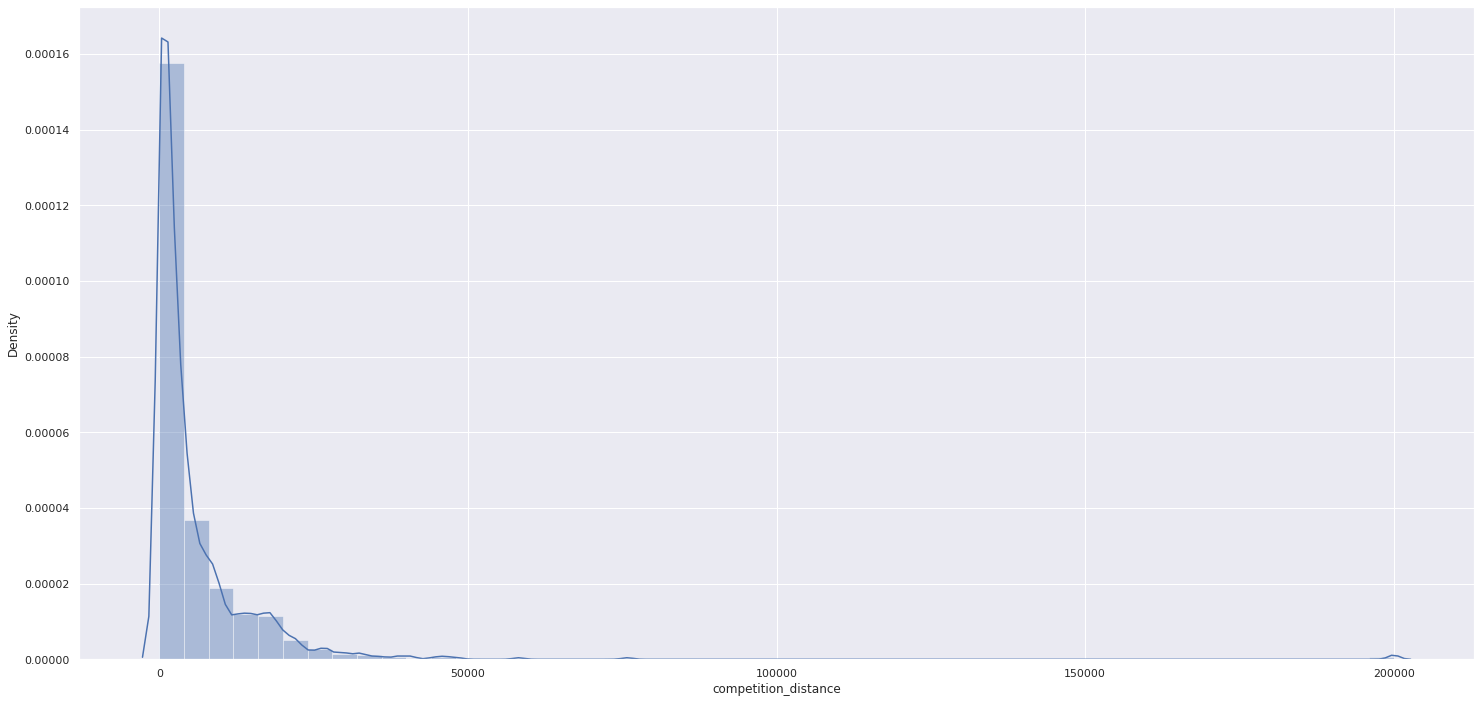

In [21]:
sns.distplot(df1['competition_distance'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

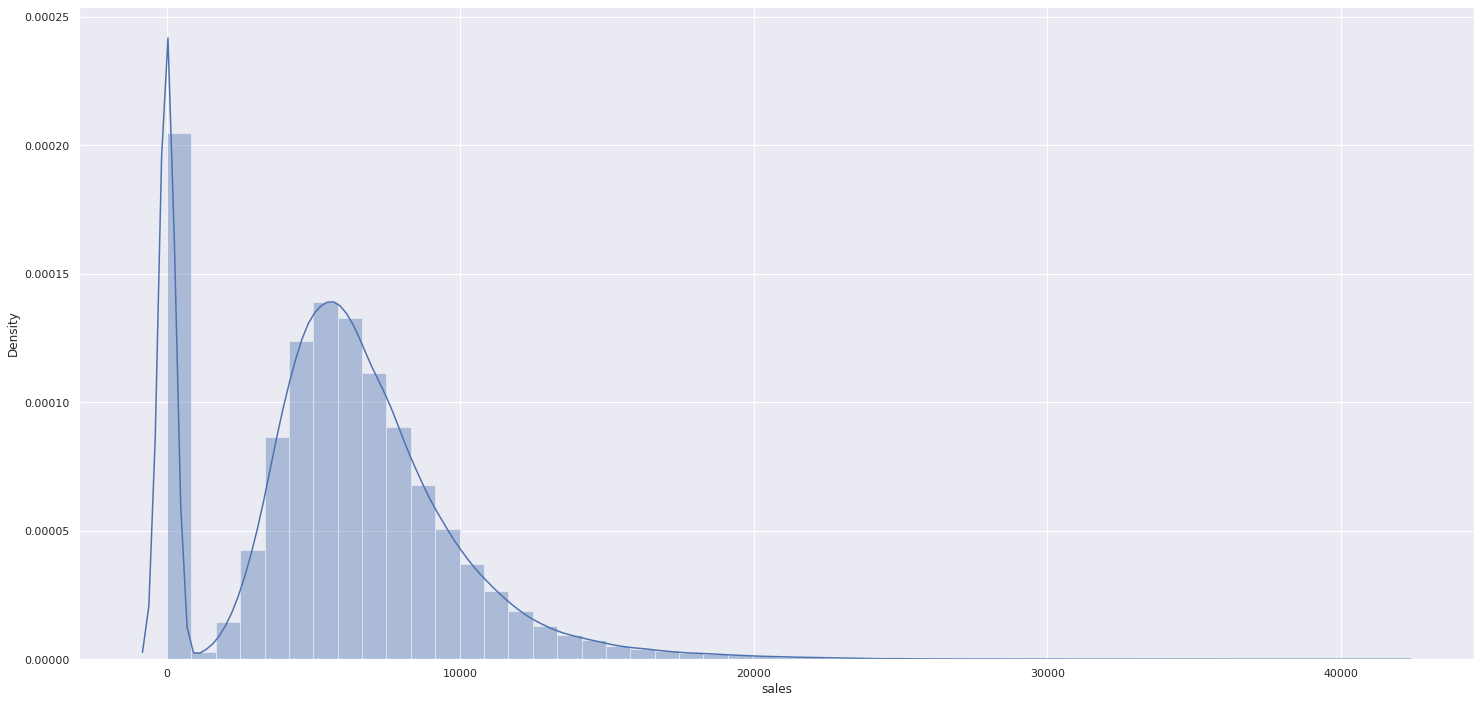

In [22]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

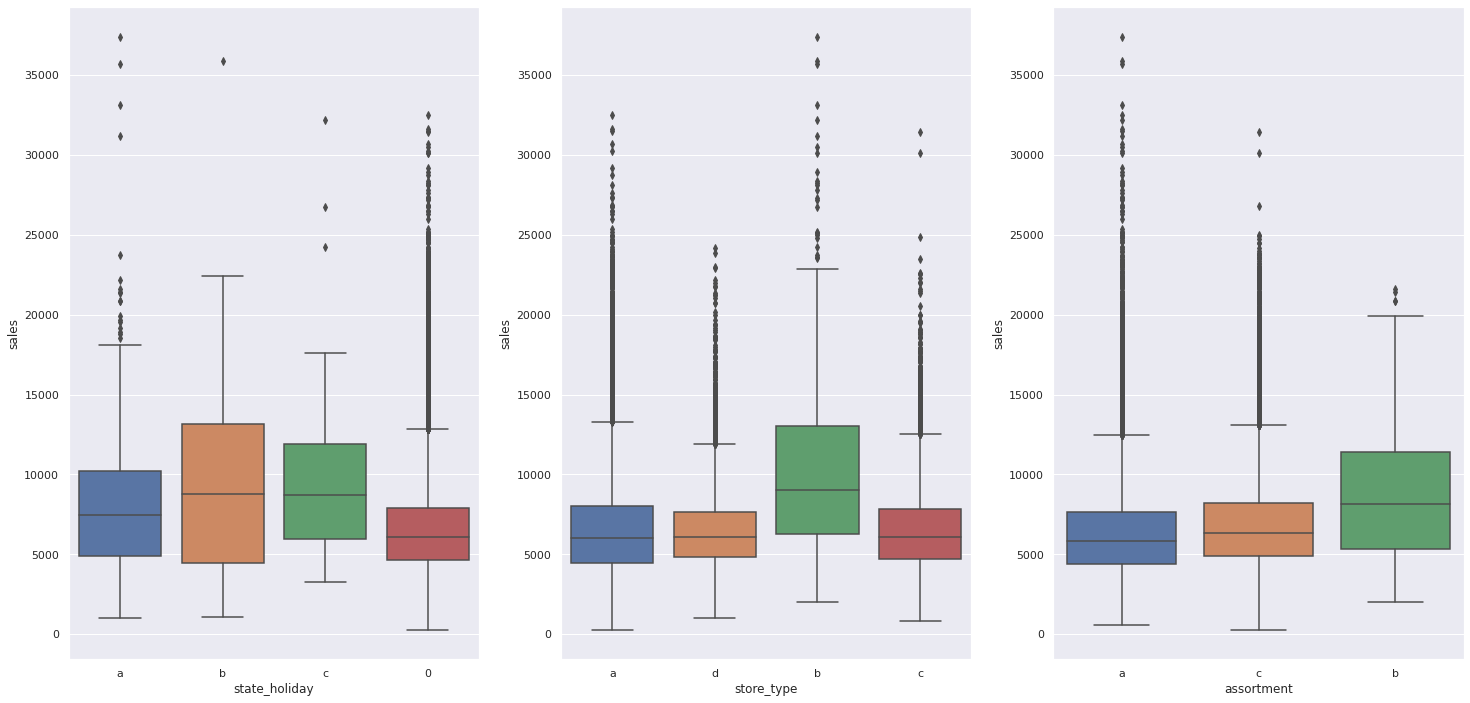

In [24]:
# box plot agregates all disperion and central tendencys in one local
#sns.boxplot(x = 'state_holiday', y = 'sales', data = df1) # the visualization is bad because the range of the data
                                                          # for example day with zero sale in the closed day
#Lets filter the days where the stores is closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

#Recordando que :
#"min" nao è o valor mìnimo e sim = Q1-1.5* (Q3-Q1)
#"max" nao è o valor màximo e sim = Q3+1.5 *(Q3-Q1)

In [25]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
1,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
2,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12,2013,0,31,2015,0,Jul,0
3,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4,2013,0,31,2015,0,Jul,0
4,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0,31,2015,0,Jul,0


# 2.0 PASSO 02 - FEATURE ENGINEERING (crisp - limpeza dos dados)

In [26]:
df2 = df1.copy()

## 2.1 Mental map hypothesis

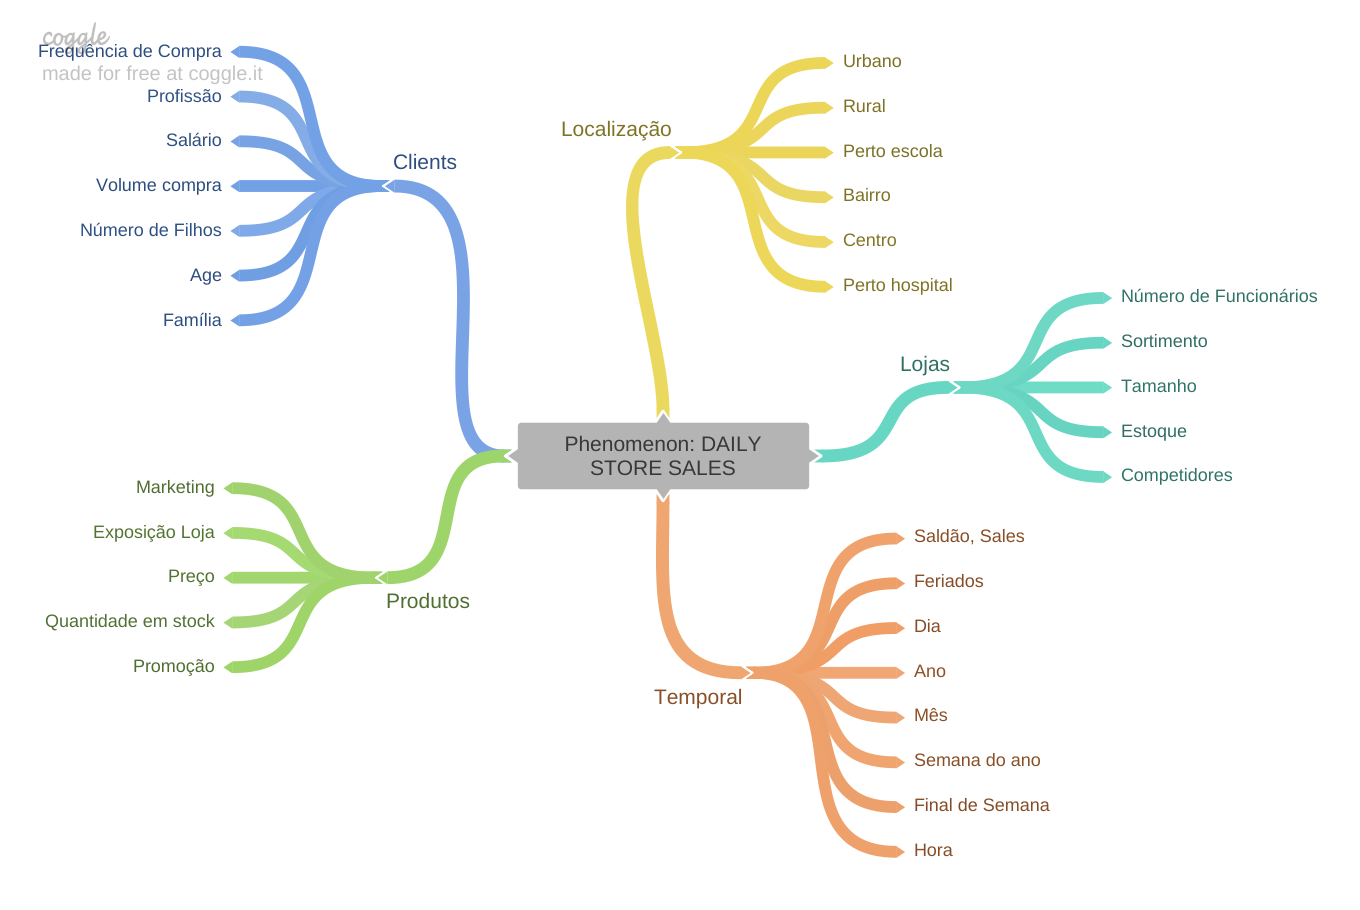

In [27]:
Image('img/mindmaphypotesis.png')

## 2.1 Hypothesis criation

### 2.1.1 Store Hypothesys

**1.** Lojas com maior quadro de funcionários vendem mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Product Hypothesys

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day = 1), 
                                                                 axis = 1)
# divided by 30 to maintain the granularity of month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# converting string to datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                             datetime.timedelta(days = 7))

# extracting datetime in days
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' 
                                                if x == 'a' 
                                                else 'extra' 
                                                if x == 'b' 
                                                else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                  if x == 'a'  
                                                  else 'easter_holiday' 
                                                  if x == 'b' 
                                                  else 'christmas' 
                                                  if x == 'c'
                                                  else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,2,3,6,7,9
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,6064,8314,5651,15344,8565
customers,625,821,589,1414,687
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,a,a,a,a,a


#  3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS (crisp - limpeza dos dados)

In [30]:
df3 = df2.copy()

In [31]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
1,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
2,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
3,7,5,2015-07-31,15344,1414,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
4,9,5,2015-07-31,8565,687,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0


## 3.1 Filtragem das linhas (to reduce the amount of data early)

In [32]:
# open -  if 0 the store is closed so 0 sales
# sales -  assume that if sales == 0, the store is closed
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [33]:
# customers - we do not have the prediction of how many customers the store will have, so we aren't use it now
# open is only 1 now, promo interval and month map was used to derive another column
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS (crisp - eda)

In [34]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

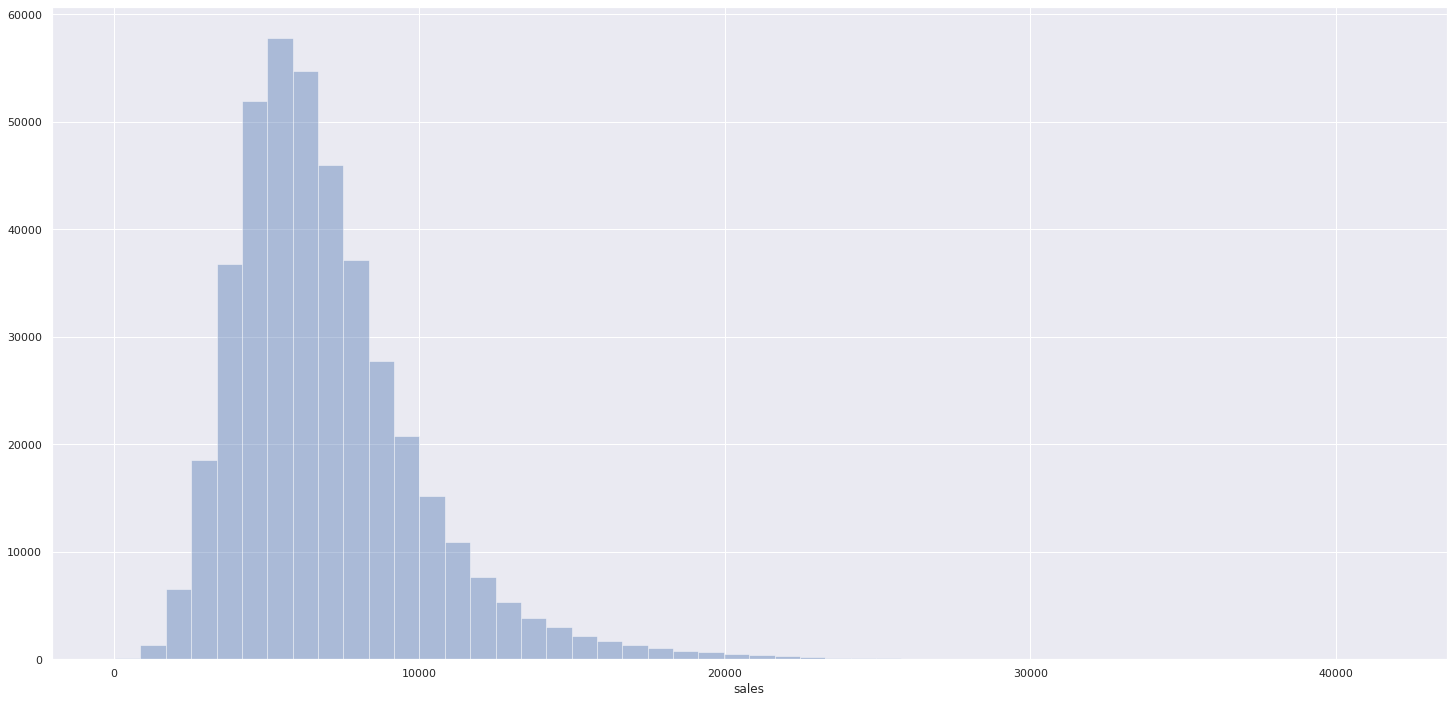

In [35]:
sns.distplot( df4['sales'], kde=False) # kde = false -> only histogram, and not the distribution

### 4.1.2. Numerical Variable

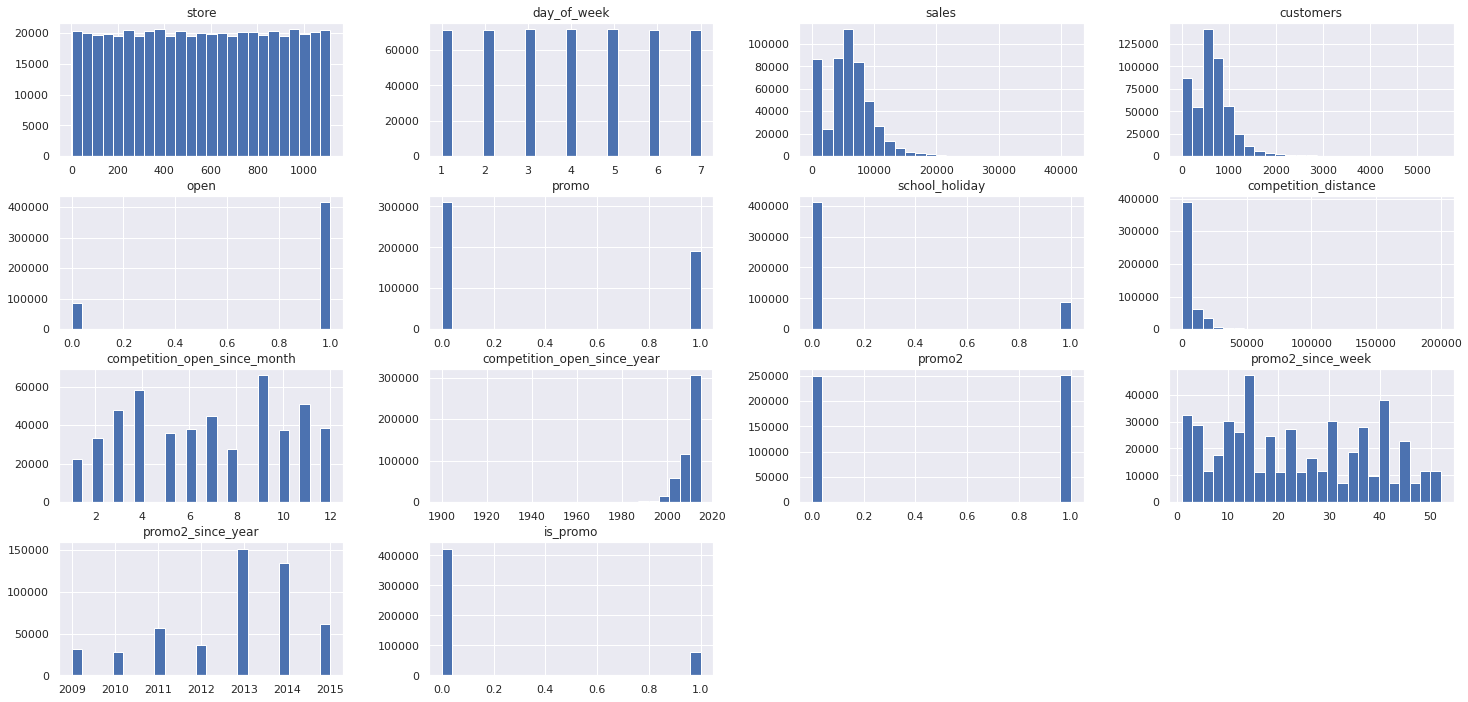

In [36]:
num_attributes.hist(bins=25); # bins quantity of bars in each graph, ; for not print logs

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

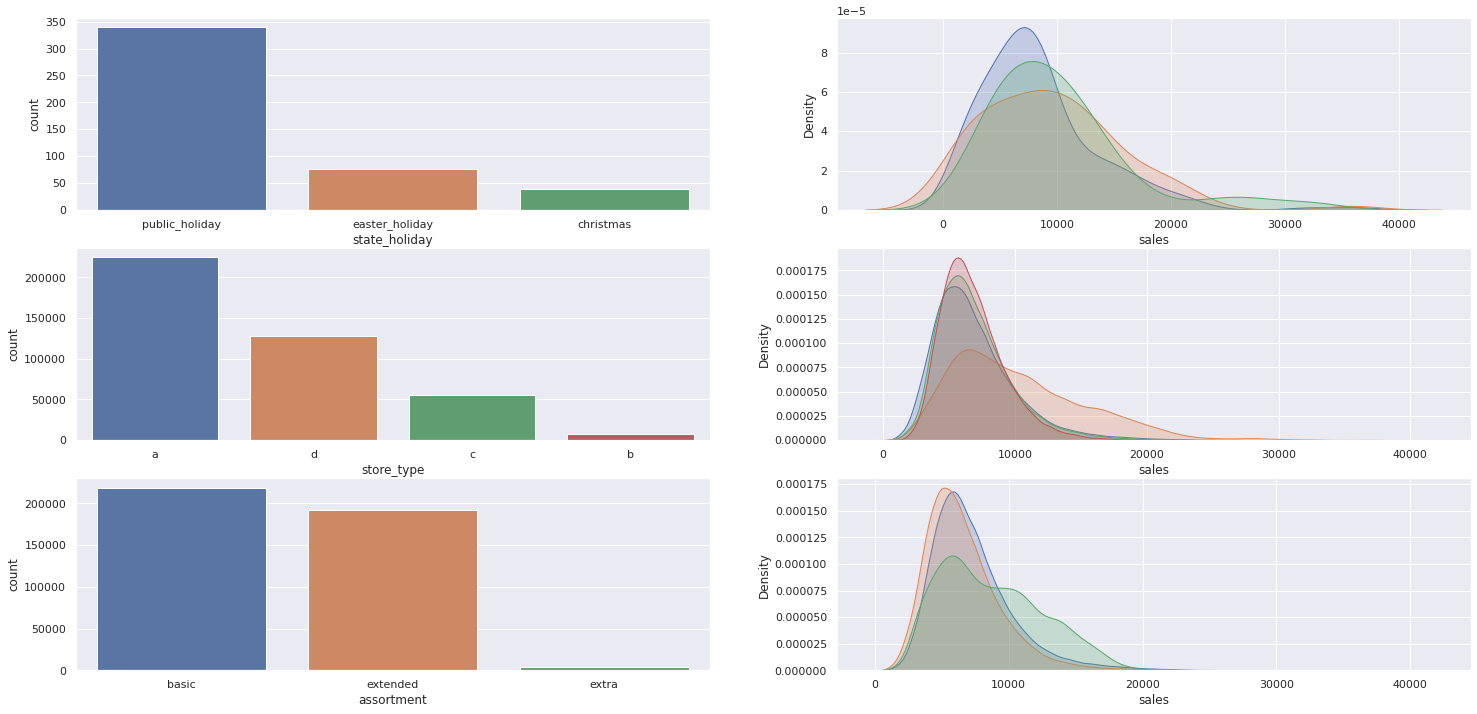

In [37]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],     label = 'christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],    label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],    label = 'extra', shade=True)

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

### FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

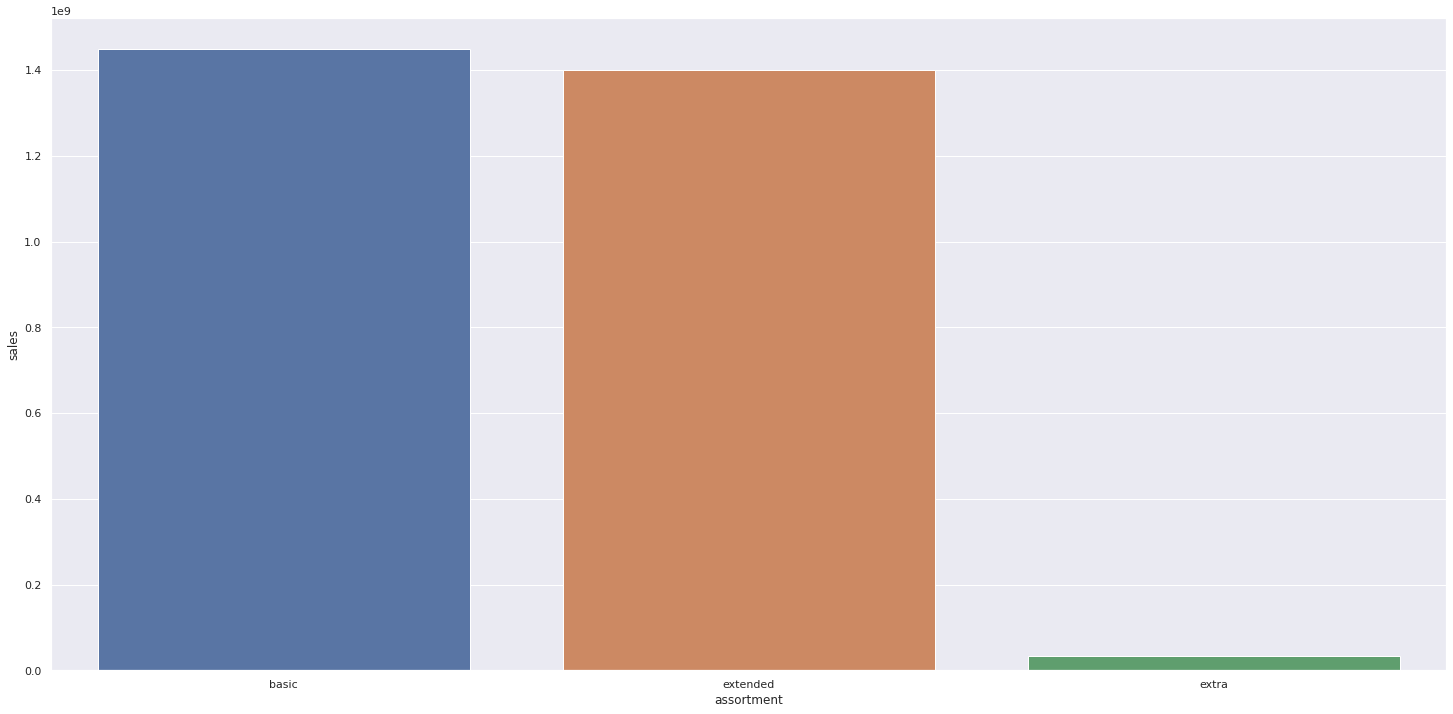

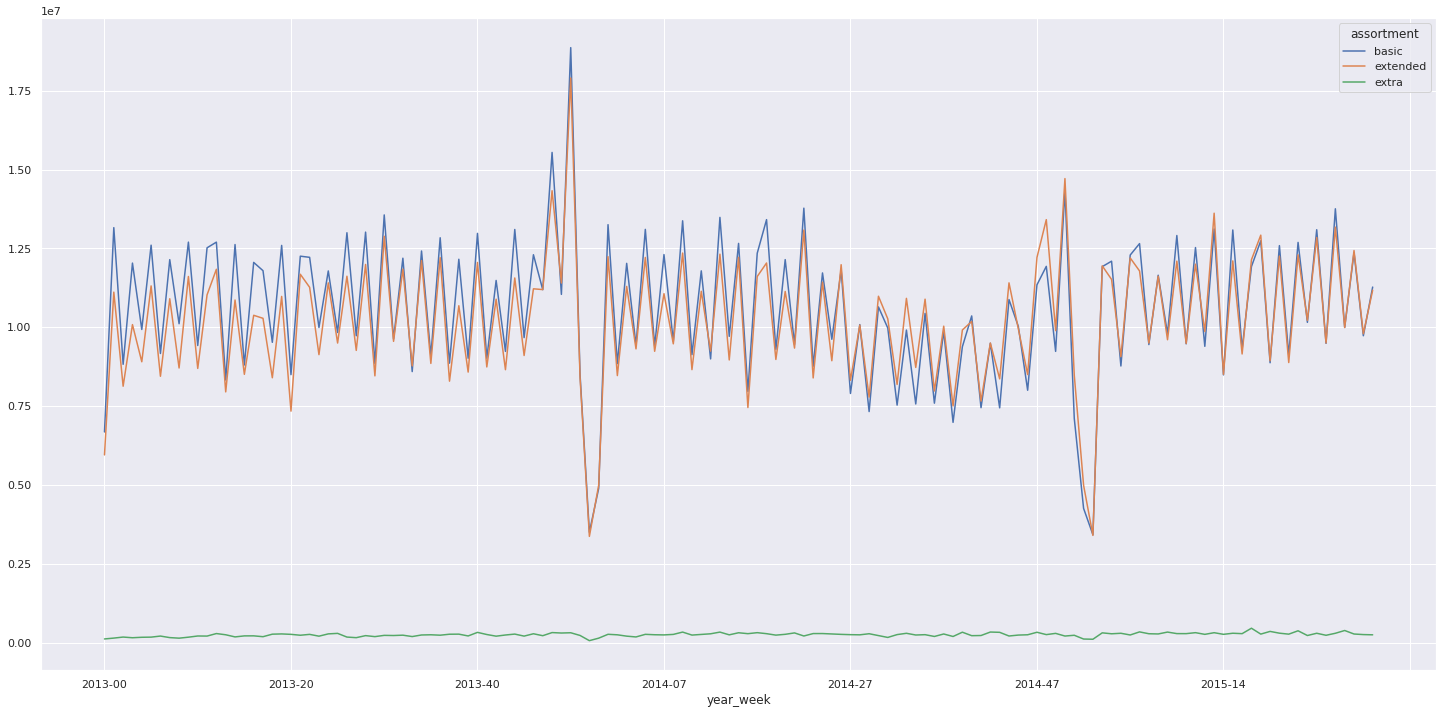

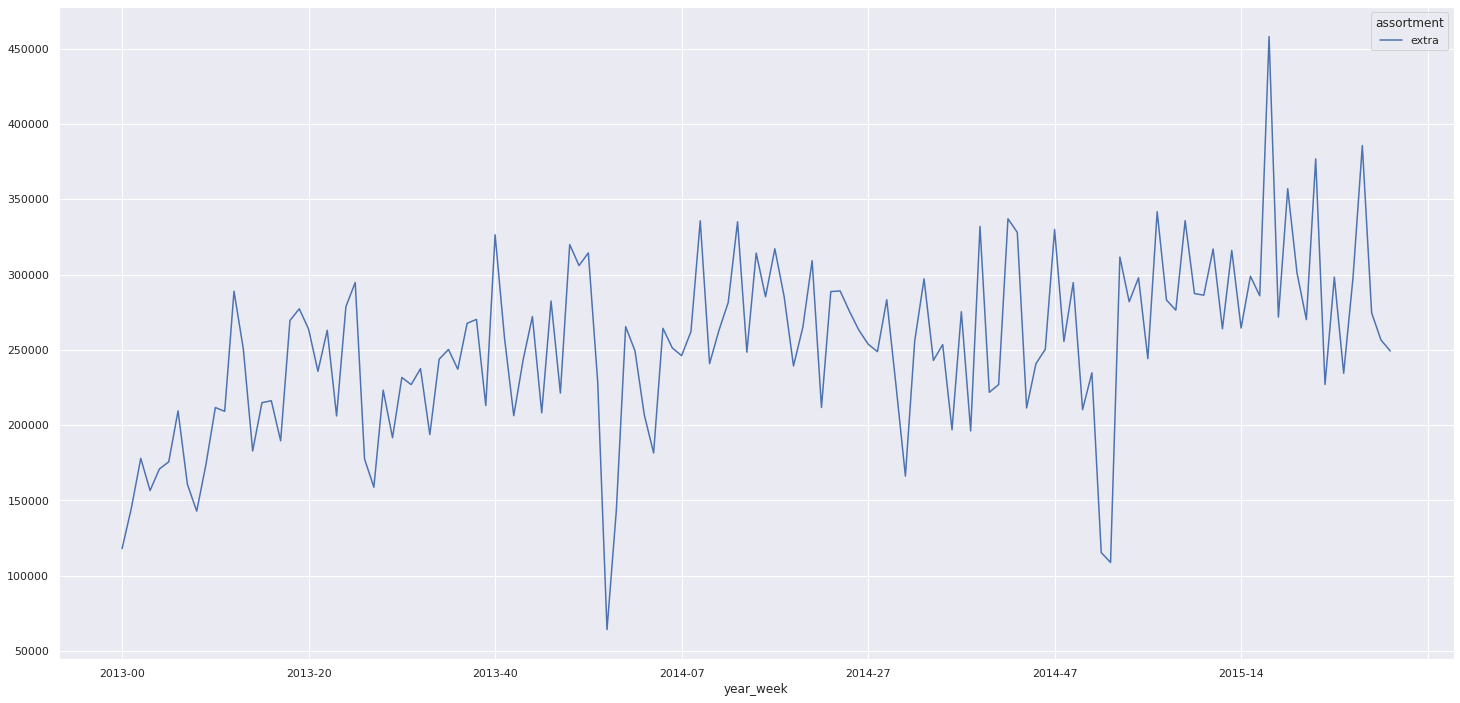

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

### FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

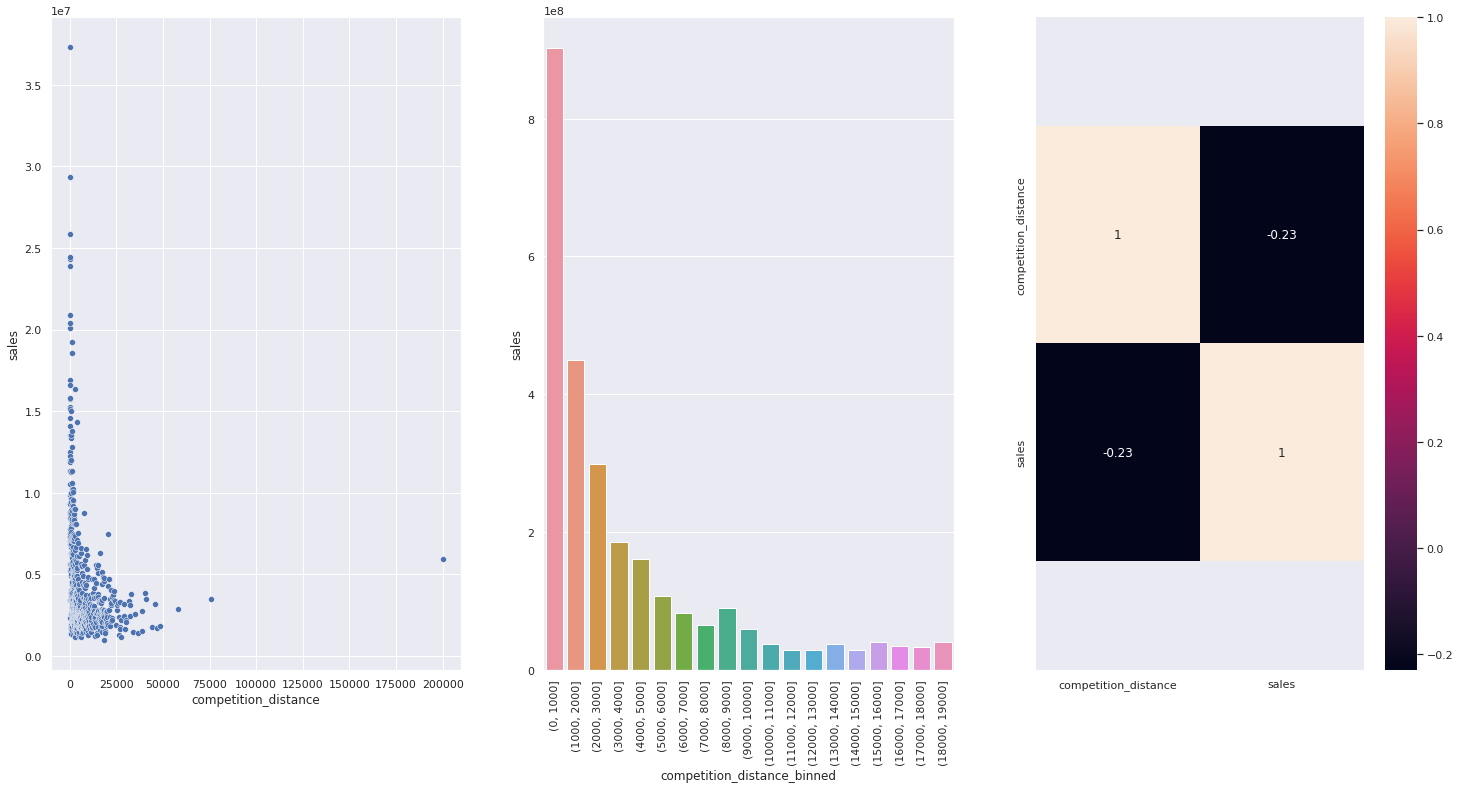

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange( 0, 20000, 1000)) # separate the values in the range of 0 to 20000, of 1000 each interval
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

### FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

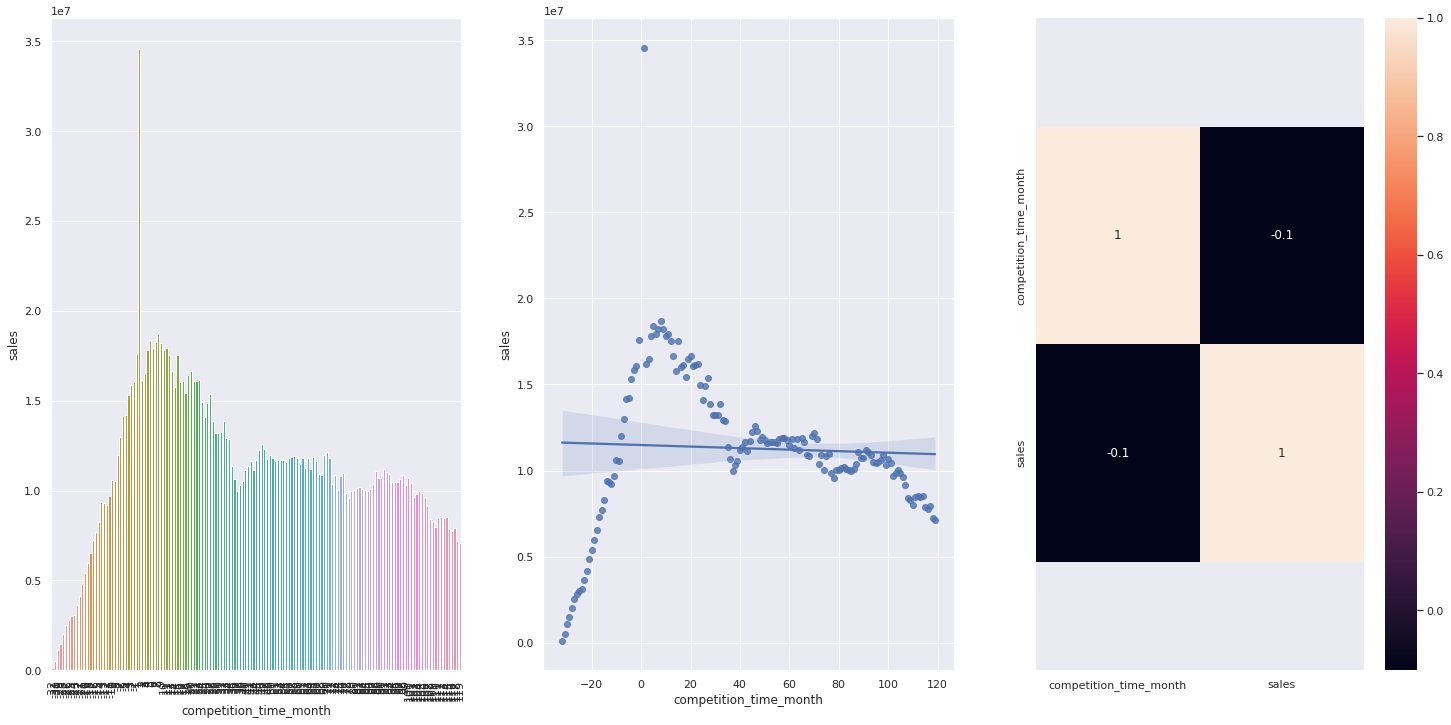

In [40]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]  # open time of competition < 120 months, and date of open equals date of dataset
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

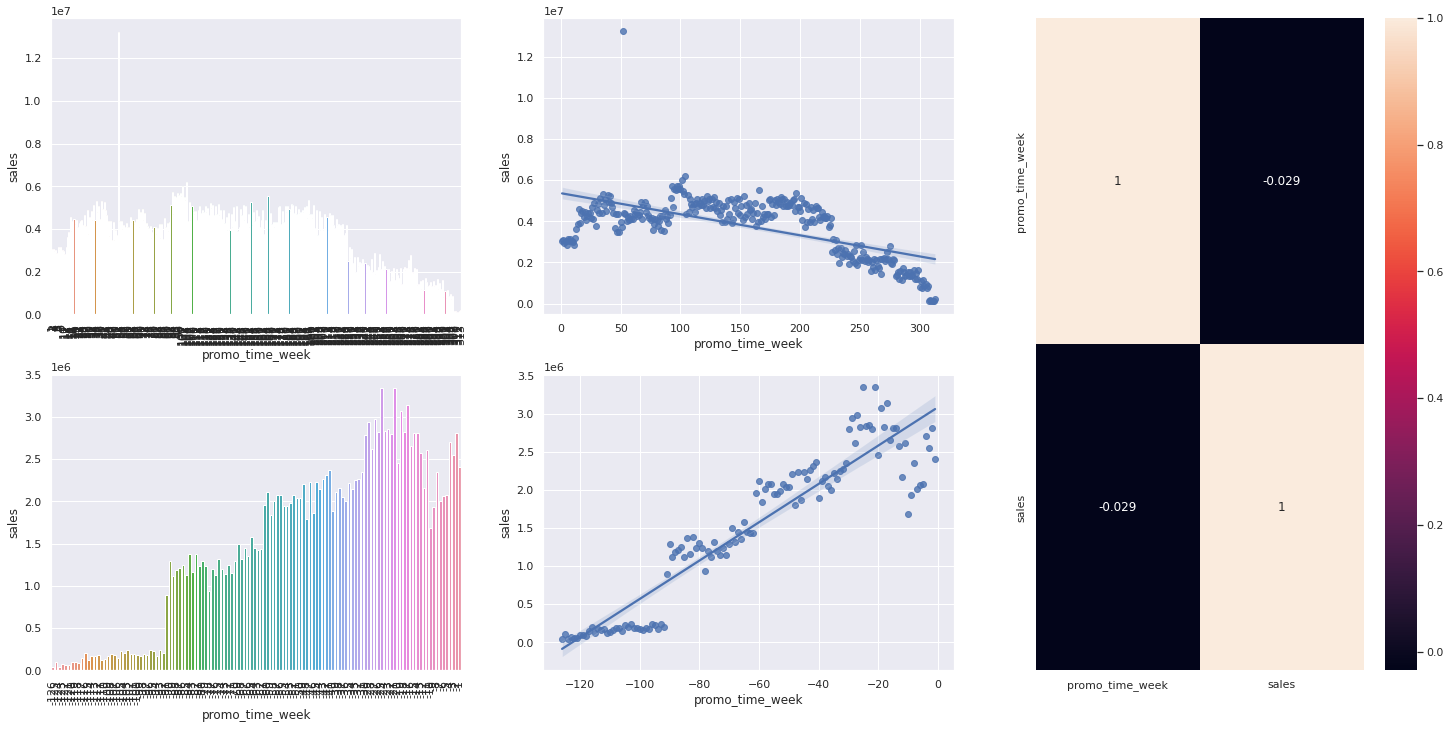

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H5. Lojas com mais dias de promoção deveriam vender mais.
### Próximo ciclo crisp

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
### FALSA Lojas com mais promocoes consecutivas vendem menos

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,729906102
1,0,1,635784305
2,1,0,796314812
3,1,1,722479605


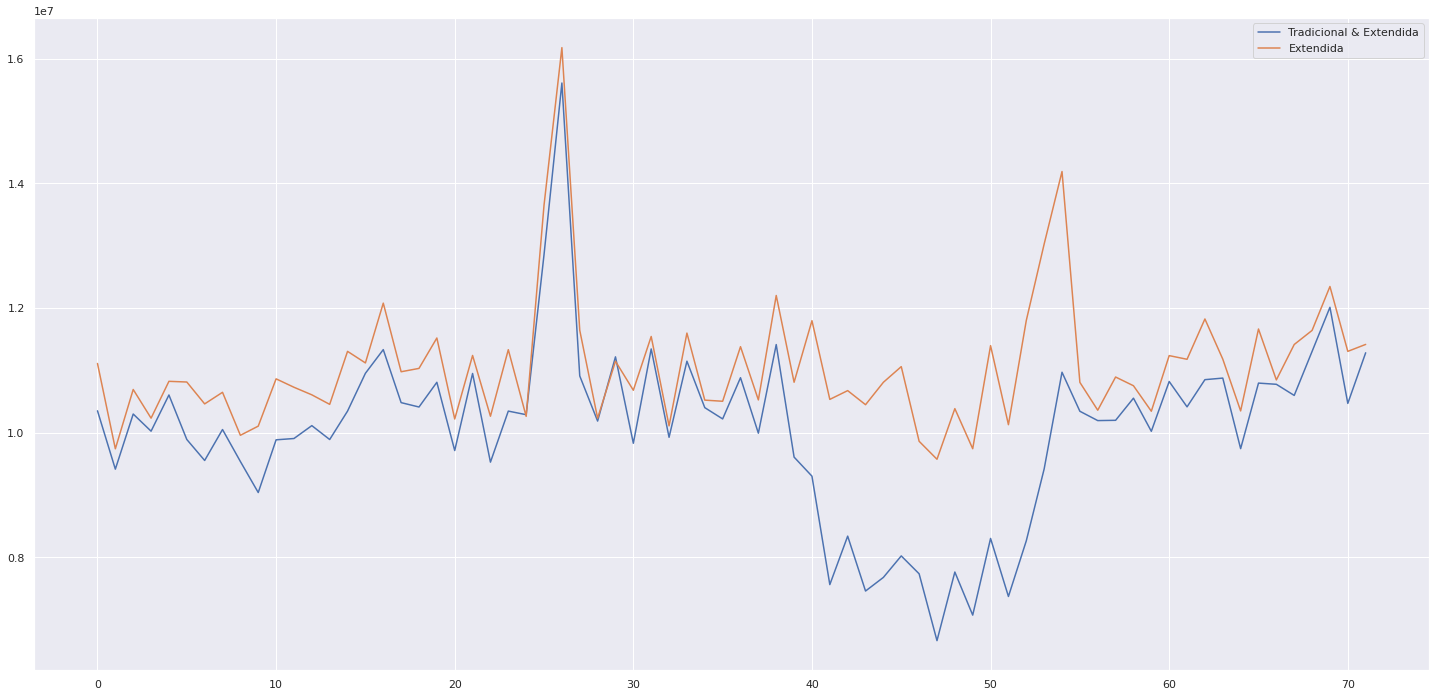

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
### FALSA Lojas abertas durante o feriado do Natal vendem menos.

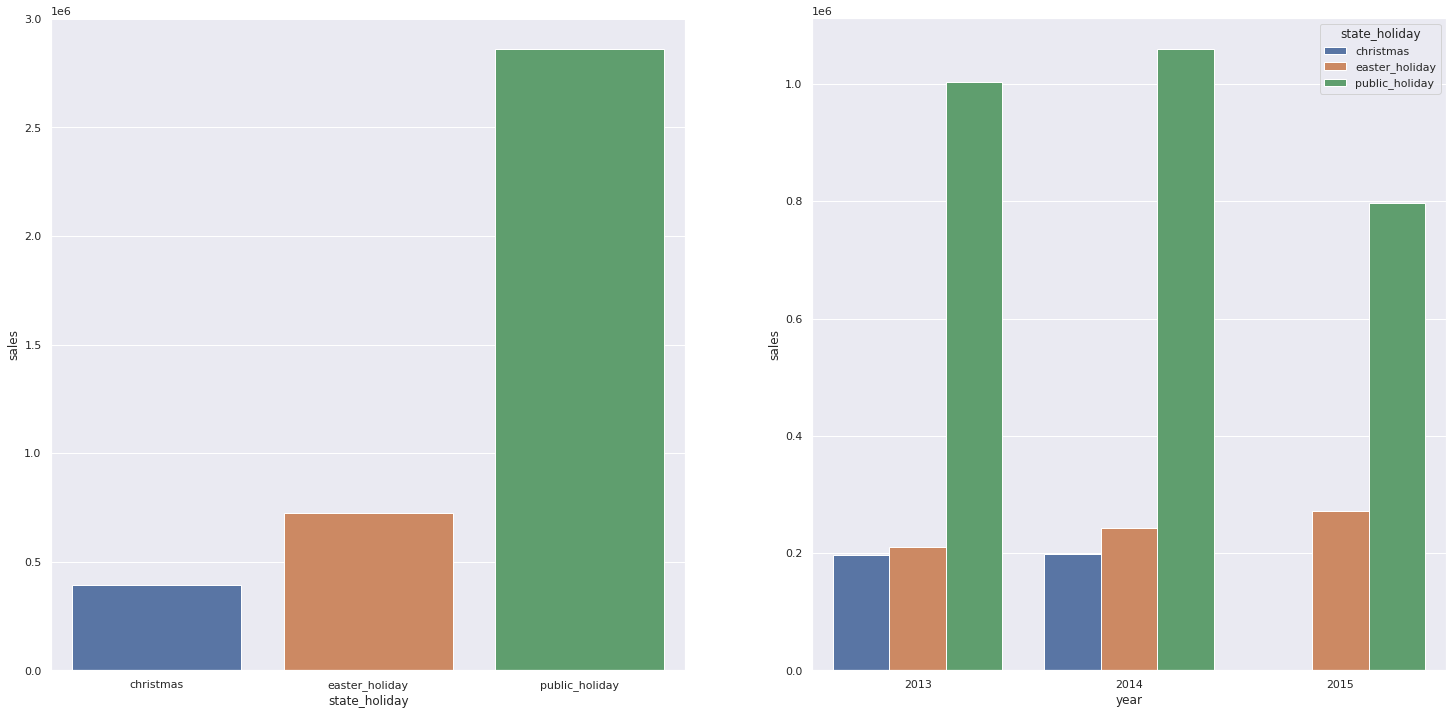

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
### FALSA Lojas vendem menos ao longo dos anos

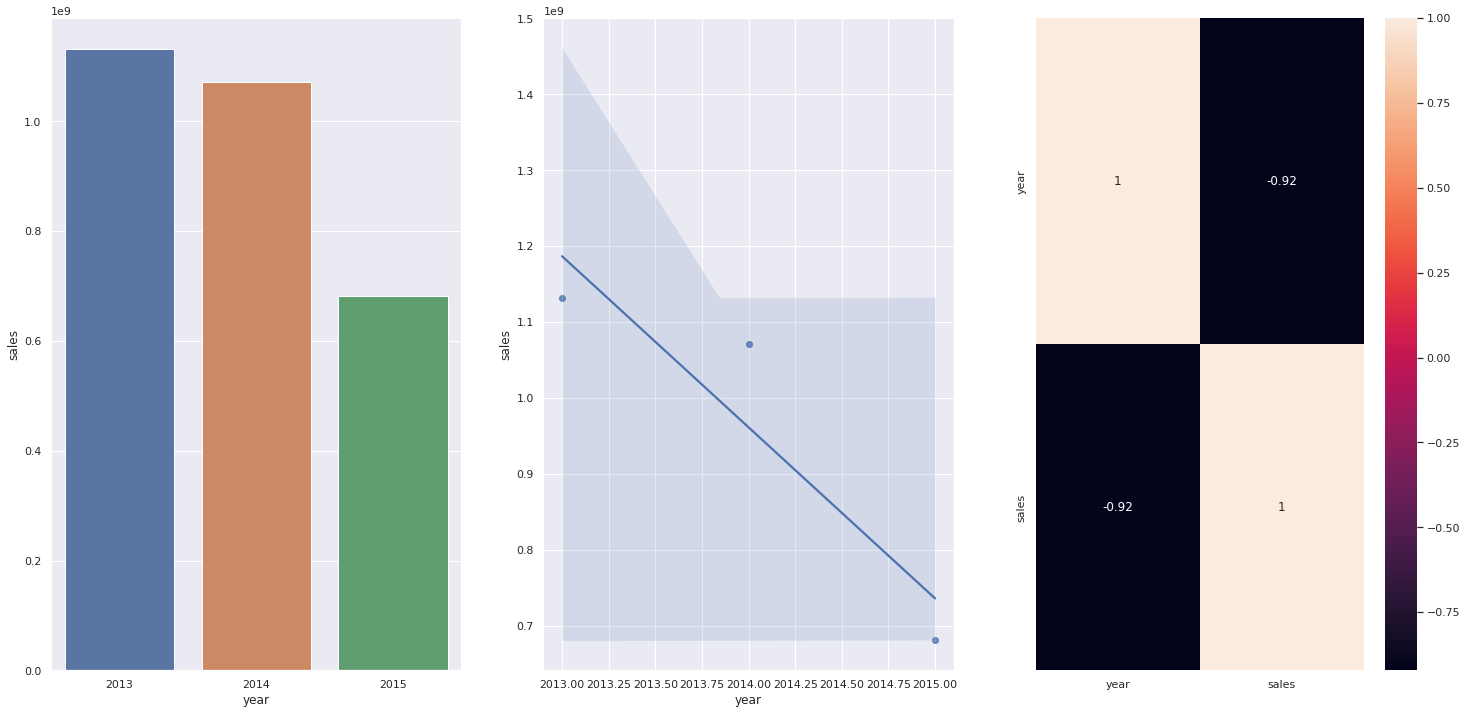

In [45]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
### FALSA Lojas vendem menos no segundo semestre do ano

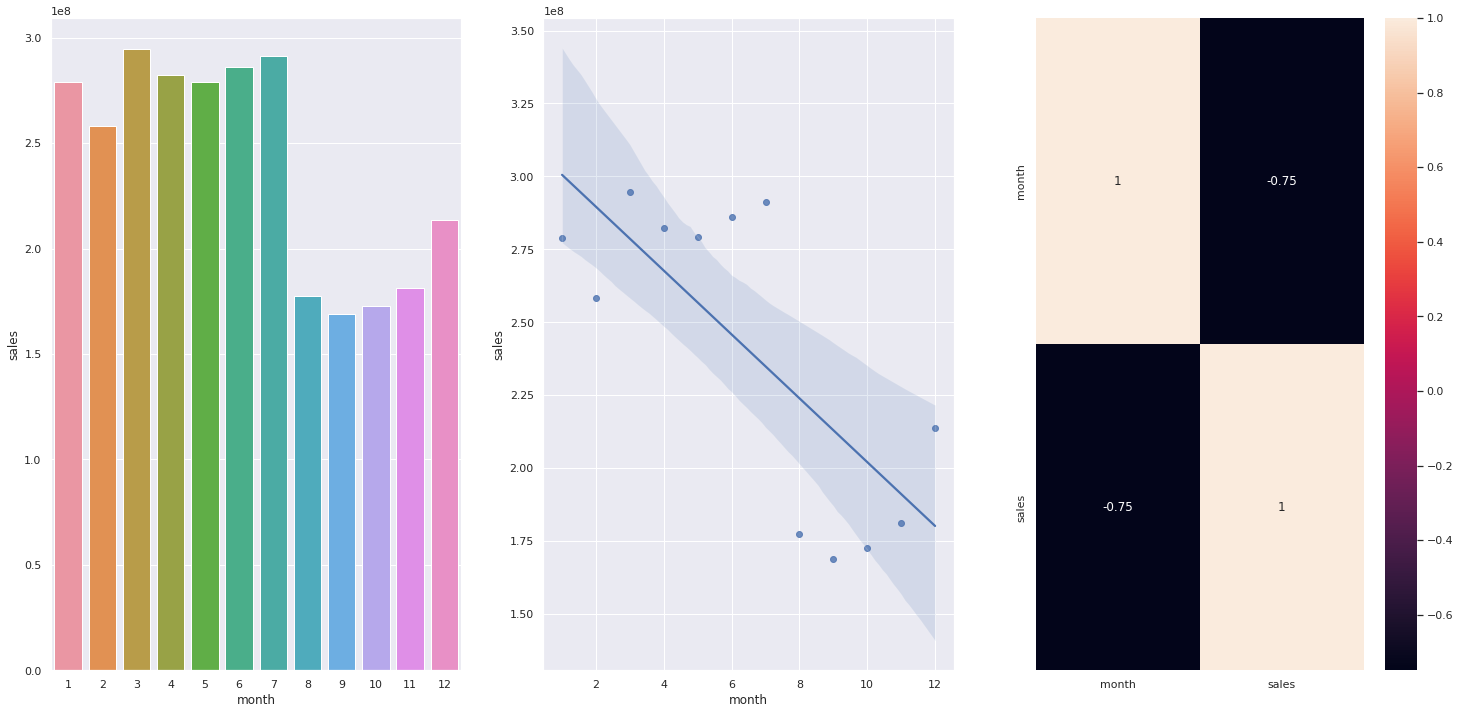

In [46]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2 )
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
### VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.

ValueError: method must be either 'pearson', 'spearman', 'kendall', or a callable, ' pearson' was supplied

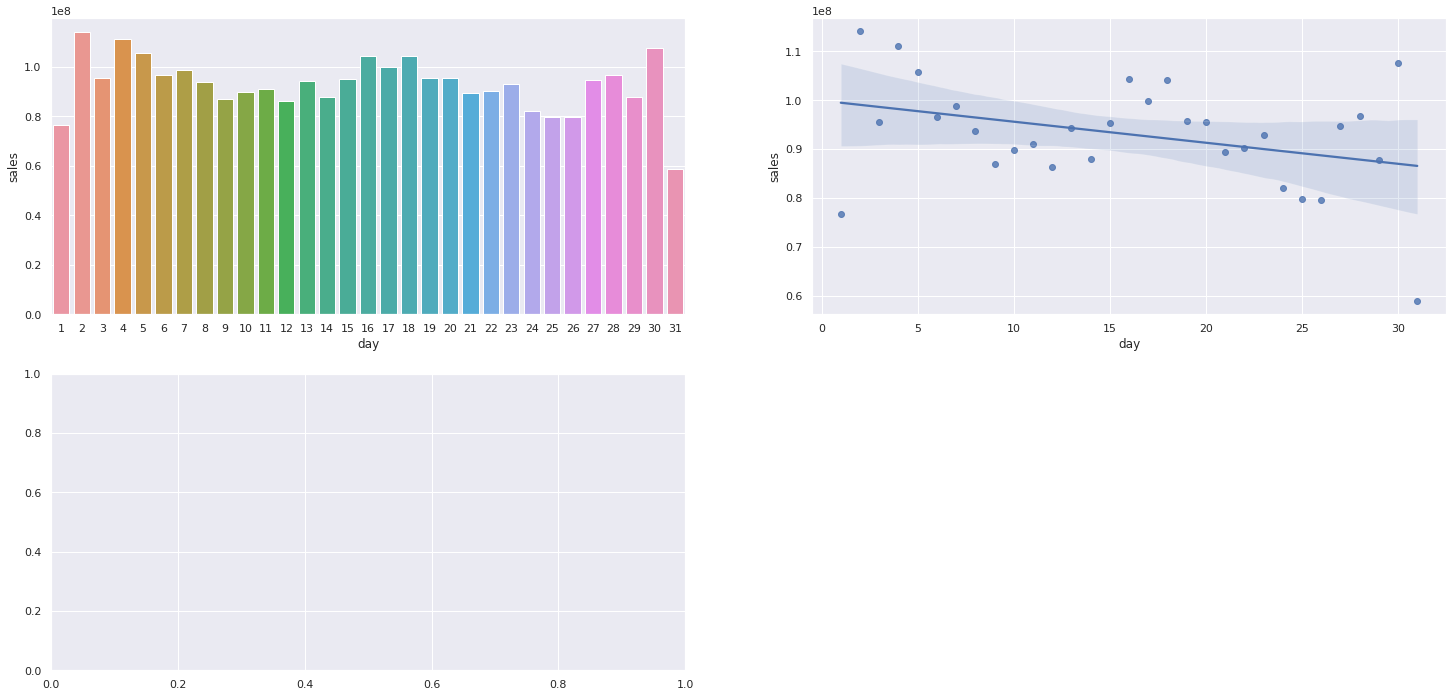

In [47]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method =' pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x =' before_after', y = 'sales', data = aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
### VERDADEIRA Lojas vendem menos nos final de semana

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
### VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = ' sales', data = aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

## 4.2.1. Resumo das Hipoteses

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hipoteses', 'Conclusao',  'Relevancia'],
      ['H1',        'Falsa',      'Baixa'],
      ['H2',        'Falsa',      'Media'],
      ['H3',        'Falsa',      'Media'],
      ['H4',        'Falsa',      'Baixa'],
      ['H5',        '-',          '-'],
      ['H6',        'Falsa',      'Baixa'],
      ['H7',        'Falsa',      'Media'],
      ['H8',        'Falsa',      'Alta'],
      ['H9',        'Falsa',      'Alta'],
      ['H10',       'Verdadeira', 'Alta'],
      ['H11',       'Verdadeira', 'Alta'],
      ['H12',       'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes(include = 'object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['store_type'],    a['state_holiday'])
a5 = cramer_v(a['store_type'],    a['store_type'])
a6 = cramer_v(a['store_type'],    a['assortment'])
a7 = cramer_v(a['assortment'],    a['state_holiday'])
a8 = cramer_v(a['assortment'],    a['store_type'])
a9 = cramer_v(a['assortment'],    a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type':    [a4, a5, a6],
                  'assortment':    [a7, a8, a9]})

d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

# 5.0. PASSO 05 - DATA PREPARATION (crisp - modelagem dos dados)

In [ ]:
df5 = df4.copy()

### 5.1. Normalizacao

In [ ]:
# rescale the center to zero with standard deviation equals 1
# Não há variáveis com distribuição normal para ser aplicado a normalização

### 5.2. Rescaling

In [ ]:
# rescale the interval between zero and 1
# applied to non gaussian distributions
# big range add bias modelling to the algorithm, the rescaling make all range be the same
# the shape of the distribution doesn't change

In [ ]:
rs  = RobustScaler()  # não afetado pelos outliers, use quartile 1, quartile 3, and IQR
mms = MinMaxScaler() # funciona bem onde não há outliers

# competition distance
# sns.boxplot(df5['competition_distance']) # to see if there is outliers
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb')) # wb por conta da escrita

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))



In [ ]:
#sns.distplot(df5['competition_distance'])
#sns.boxplot(df5['competition_distance']) # to see if there is outliers

### 5.3. Transformacao

#### 5.3.1. Encoding

In [ ]:
# categoric -> numeric feature

In [ ]:
# state_holiday - One Hot Encoding (creates new columns)
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding (just change the names by numbers)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding (related to hierarchical sequence numbers)
assortment_dict   = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2. Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales']) # change the shape to a normal distribution (benefit the algorithm)
#sns.distplot(df5['sales'])

#### 5.3.3. Nature Transformation

In [ ]:
# apply ciclycal atribute to the time columns

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - FEATURE SELECTION (crisp - modelagem dos dados)

In [ ]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [ ]:
# delete columns that were used to generate others, or are not necessary anymore
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [ ]:
df6[['store', 'date']].groupby('store').min().reset_index() # start date
df6[['store', 'date']].groupby('store').max().reset_index() # final date

# excluding the last 6 weeks from de dataset to generate the training dataset
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'. format(X_train['date'].min()))
print('Training Max Date: {}'. format(X_train['date'].max()))

print('\nTest Date Min Date: {}'. format(X_test['date'].min()))
print('Test Max Date: {}'. format(X_test['date'].max()))

## 6.2 Boruta as Feature Selector (4 to 5 hours)

In [ ]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values # delete training features, values to get only values 
                                                             # and not send a datframe to the algoritm
#y_train_n = y_train.values.ravel() # ravel is to vetorize the values got

In [ ]:
# define randomforestregressor
#rf = RandomForestRegressor(n_jobs = -1) # so the commando will use all machine cores and meake the tree in paralel

In [ ]:
# Define boruta
# rf - random forest, estimators automatic, verbose to the command print the logs, random state to select the 
# variables with the same aleatority
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)  # to feed the next command with an entire dataframe, and
                                                        # not just values (fs - feature select)

In [ ]:
# iloc because we are now working with index and not names
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

In [ ]:
# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta)) # compare columns and
                                                                                  # give the ones that is not on
                                                                                  # the selected list

## 6.3 Manual Feature Selection

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin', # added
    'month_cos',  
    'day_sin',
    'day_cos',
    'week_of_year_sin', #added
    'week_of_year_cos']

# columns to add
# adding date to separate the dataset later and sales to train the algorithm
feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend(feat_to_add)


In [ ]:
cols_selected_boruta

# 7.0 PASSO 07 - MACHINE LEARNING MODELING (crisp - ml algorithm)

In [ ]:
# initially without date and sales
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

# adding date and sales again to separate training and validation for time series

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# Time series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales' : 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['prediction'] # hat to indicate prediction

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # y_test -> real values
                                                                                       # exp makes the antilog
                                                                                       # from section 5
        
baseline_result

## 7.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv 

## 7.3 Linear Regression Regularized Model

In [ ]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train) # alpha serve para limitar os pesos

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv 

## 7.4 Random Forest Regressor

In [ ]:
# model
# n_estimators -> size tree  |  n_jobs -> to run in parallel  |  random_state -> aleatority source
rf = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train, y_train)

In [ ]:
# prediction
yhat_rf = rf.predict(x_test)

In [ ]:
# performance
rf_result = ml_error('Random forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv 

## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = 25,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

In [ ]:
# prediction
yhat_xgb = model_xgb.predict(x_test)

In [ ]:
# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
xgb_result_cv 

## 7.6 Compare model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv
# even the performance of XGBoost Regressor is not the best for academic purpose this model will be used

# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING (crisp - ml algorithm)

## 8.1 Random Search

In [ ]:
param = {'n_estimators':     [1500, 1700, 2500, 3000, 3500],
         'eta':              [0.01, 0.03],
         'max_depth':        [3, 5, 9],
         'subsample':        [0.01, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame() # empty dataframe
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    #hp = {k: random.sample(v, 1)[0] for k, v in param.items()} # k -> keas, v -> values
#    hp = {k: np.random.choice(v, 1)[0] for k, v in param.items()}
#    print(hp)
#     
#    # model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'], # training is made by cross validation function
#                                 min_child_weight = hp['min_child_weight'])
#    
#        
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
#    final_result = pd.concat([final_result, result])
#
#final_result # ~ 2 days

## 8.2 Final Model

In [ ]:
# from early result
param_tuned = {'n_estimators':     1700,
               'eta':              0.03,
               'max_depth':        5,
               'subsample':        0.7,
               'colsample_bytree': 0.3,
               'min_child_weight': 3}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = param_tuned['n_estimators'],
                             eta = param_tuned['eta'],
                             max_depth = param_tuned['max_depth'],
                             subsample = param_tuned['subsample'],
                             colsample_bytree = param_tuned['colsample_bytree'], # training is made by cross validation function
                             min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

In [ ]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [ ]:
# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned # ~ 2 hours

In [ ]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))


In [ ]:
xgb_result_tuned['MPE'] = mpe
xgb_result_tuned

# 9.0 PASSO 9 - TRADUCAO E INTERPRETACAO DO ERRO (crisp - algorithm analisys)

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales']      = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
# sum of prediction
df91     = df9[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: 
                    mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: 
        mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92     = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario']  = df92['prediction'] + df92['MAE']

# order columns
df92 = df92[['store', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
# showing stores with difficult analisys
df92.sort_values('MAPE', ascending = False).head()

In [ ]:
df92.head()

In [ ]:
# showing it graficaly
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

## 9.2 Total Performance

In [ ]:
df93 = df92[['prediction', 'worst_scenario', 'best_scenario']].apply(
                                                            lambda x: np.sum(x), axis = 0).reset_index().rename(
                                                            columns = {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

## 9.3 Machine Learning Performance

In [ ]:
df9['error']      = df9['sales']      - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['sales']

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales',      data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'prediction', data = df9, label = 'PREDICTION')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9, label = 'SALES')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['prediction'], df9['error'])

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION (crisp - modelo em produção)

In [ ]:
# Save trained model
pickle.dump(model_xgb_tuned, open('/home/work/Documents/repos/curso_data_science_em_producao/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import math
import datetime
import numpy as np


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/work/Documents/repos/curso_data_science_em_producao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb')) # rb por conta da leitura
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
    
    def data_cleaning(self, df1):
    
        #1.1 Rename Columns
    
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',   # sales and customer deleted
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
    
        cols_new = list(map(snakecase, cols_old))
    
        # rename
        df1.columns = cols_new


        ## 1.3 Data Types
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        
        # competition_distance: we are assuming tha when there is no competition distance, the competition doesn't exists 
        # at all, so we assumy tha this distance will be 200000, a number much higher than the value 75860.0
        
        # 200000.0 if math.isnam(df1['competition_distance']) else df1['competition_distance']
        # lambda x: 200000.0 if math.isnam(x['competition_distance']) else x['competition_distance']
        # df1['competition_distance'].apply(lambda x: 200000.0 if math.isnam(x) else x)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        # competition_open_since_month: we are assuming that the month of competition openning is the same as the month of 
        # the sale column
        df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(
                                                                lambda x: x['date'].month 
                                                                if math.isnan(x['competition_open_since_month']) 
                                                                else x['competition_open_since_month'],
                                                                axis = 1) # because we are using more than one column, we 
                                                                # need do specify that apply function will be apllied along
                                                                # the columns.
        
        # competition_open_since_year     
        df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(
                                                                lambda x: x['date'].year 
                                                                if math.isnan(x['competition_open_since_year']) 
                                                                else x['competition_open_since_year'],
                                                                axis = 1)
                               
        # promo2_since_week: we are assuming the same date of the row, i.e., the store doesn't make the promo2
        df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(
                                                               lambda x: x['date'].week 
                                                               if math.isnan(x['promo2_since_week']) 
                                                               else x['promo2_since_week'],
                                                                axis = 1)
        
        # promo2_since_year  
        df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year 
                                                                if math.isnan(x['promo2_since_year']) 
                                                                else x['promo2_since_year'],
                                                                axis = 1)
        
        # promo_interval: built a list and if the date is on the list the promo was made
        # dictionare
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 
                     11: 'Noc', 12: 'Dec'}
        
        # fill with 0 where in no values
        df1['promo_interval'].fillna(0, inplace = True) # inplace so the command doesn't return any value and make the 
                                                        # modification directly to the column
        
        df1['month_map'] = df1['date'].dt.month.map(month_map) # trasnform date column in date and month, and substitute
                                                               # the numbers by letters
        
        # if the months of 'month_map' are in 'promo_interval', so we assume that the store make the promo and the time
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                                     if x['promo_interval'] == 0 
                                                                     else 1 
                                                                     if x['month_map'] in x['promo_interval'].split(',') 
                                                                     else 0, 
                                                                     axis = 1)
        
        
        ## 1.6 Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
    # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                         month = x['competition_open_since_month'], 
                                                                         day = 1), 
                                                                         axis = 1)
        # divided by 30 to maintain the granularity of month
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        # converting string to datetime
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                     datetime.timedelta(days = 7))
        
        # extracting datetime in days
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' 
                                                        if x == 'a' 
                                                        else 'extra' 
                                                        if x == 'b' 
                                                        else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                          if x == 'a'  
                                                          else 'easter_holiday' 
                                                          if x == 'b' 
                                                          else 'christmas' 
                                                          if x == 'c'
                                                          else 'regular_day')
        


        ## 3.1 Filtragem das linhas (to reduce the amount of data early)
        
        # open -  if 0 the store is closed so 0 sales
        df2 = df2[(df2['open'] != 0)]
        
        ## 3.2 Seleção das colunas
        
        # customers - we do not have the prediction of how many customers the store will have, so we aren't use it now
        # open is only 1 now, promo interval and month map was used to derive another column
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    

    def data_preparation(self, df5):

        ### 5.2. Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )
                
        ### 5.3. Transformacao
        
        #### 5.3.1. Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        #### 5.3.3. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
            'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',  'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2 API Handler

In [ ]:
import pickle
import json
import pandas as pd
from flask import Flask, request, Response

from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/work/Documents/repos/curso_data_science_em_producao/model/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST']) # endpoint | method que envia algo, e não solicita informação
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example (one row)
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0') # to run locally

## 10.3 API Tester

In [1]:
import requests

In [2]:
# loading test dataset
df10 = pd.read_csv('/home/work/Documents/repos/curso_data_science_em_producao/data/test.csv')

NameError: name 'pd' is not defined

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([4, 23, 25 ])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


In [ ]:
# converting dataframe to jason, for transmiting the archive between instances
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url    = 'https://botapp-rossmann.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data   = data

r = requests.post(url, data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction']))

In [ ]:
data